In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [7]:
def LinePlaneCollision(planeNormal, planePoint, rayDirection, rayPoint, epsilon=1e-20):
 
    ndotu = planeNormal.dot(rayDirection)
    if abs(ndotu) < epsilon:
        return None
        #        raise RuntimeError("no intersection or line is within plane")
 
    w = rayPoint - planePoint
    si = -planeNormal.dot(w) / ndotu
    Psi = w + si * rayDirection + planePoint
    return Psi

In [8]:
def LineCircleCollision(circRadius, planeNormal, planePoint, rayDirection, rayPoint, epsilon=1e-20):
    planeIntersection = LinePlaneCollision(planeNormal, planePoint, rayDirection, rayPoint)
    return planeIntersection if np.sqrt(planeIntersection[0]**2 + planeIntersection[1]**2) <= circRadius else None

In [9]:
def LineCylinderCollision(cylRadius, cylCircleCenter, rayDirection, rayPoint):
    a = rayDirection[0]**2 + rayDirection[1]**2
    b = 2*(rayDirection[0]*rayPoint[0] + rayDirection[1]*rayPoint[1])
    c = rayPoint[0]**2 + rayPoint[1]**2 - cylRadius**2
    b24ac = b*b - 4*a*c
    
    if b24ac < 0:
        return  #No intersection
     
    sqb24ac = np.sqrt(b24ac)
    t0 = (-b + sqb24ac) / (2 * a)
    t1 = (-b - sqb24ac) / (2 * a)
            
    x = np.array([rayPoint[0] + t0 * rayDirection[0], rayPoint[0] + t1 * rayDirection[0]])
    y = np.array([rayPoint[1] + t0 * rayDirection[1], rayPoint[1] + t1 * rayDirection[1]])
    z = np.array([rayPoint[2] + t0 * rayDirection[2], rayPoint[2] + t1 * rayDirection[2]])
    
    x = x[z.argsort()]
    y = y[z.argsort()]
    z = z[z.argsort()]
    
    if z[0] > cylCircleCenter[1][2] or  z[1] < cylCircleCenter[0][2]:
        return None
    
    if z[0] < cylCircleCenter[0][2] and z[1] > cylCircleCenter[1][2]:
        return np.array([LineCircleCollision(cylRadius, np.array([0, 0, 1]), cylCircleCenter[0], rayDirection, rayPoint),
                         LineCircleCollision(cylRadius, np.array([0, 0, 1]), cylCircleCenter[1], rayDirection, rayPoint)])

    if z[0] > cylCircleCenter[0][2] and z[1] < cylCircleCenter[1][2]:
        return np.array([np.array([x[0], y[0], z[0]]), np.array([x[1], y[1], z[1]])])
    
    if z[0] < cylCircleCenter[0][2]:
        return np.array([LineCircleCollision(cylRadius, np.array([0, 0, 1]), cylCircleCenter[0], rayDirection, rayPoint),
                         np.array([x[1], y[1], z[1]])])
    if z[1] > cylCircleCenter[1][2]:
        return np.array([np.array([x[0], y[0], z[0]]), 
                         LineCircleCollision(cylRadius, np.array([0, 0, 1]), cylCircleCenter[1], rayDirection, rayPoint)])
    else:
        print(f'Weird, zmin, max = {z[0]} , {z[1]}.')

In [10]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [11]:
def sphe2cart(rho, phi, theta):
    x = rho * np.cos(phi) * np.sin(theta)
    y = rho * np.sin(phi) * np.sin(theta)
    z = rho * np.cos(theta)
    return(x, y, z)

## Test example

This example assumes a point source and a circular region of interest of 5 mm radius ($r$). The source is located on the axis of the circular region at a distance of 4.3 mm ($d$). Therefore the fraction of events travessing the region of interest will be:

$\Omega$ = $2\pi\cdot(1-\cos{\theta}) \rightarrow \epsilon = \frac{\Omega}{4\pi} = \frac{1}{2} \cdot \big(1 - \frac{d}{\sqrt{d^2 + r^2}}\big) = 0.17398 = 17.398\%$

In [13]:
n_events    = 10000
r_source    = 0.

source_pos = list(pol2cart(np.sqrt(np.random.rand(n_events))*r_source, 2*np.pi*np.random.rand(n_events)))
source_pos.append(np.array(n_events*[0.]))
source_pos = np.array(source_pos).T

source_dir = np.array(sphe2cart([1]*n_events, 
                                2*np.pi*np.random.rand(n_events), 
                                np.arccos(2*np.random.rand(n_events)-1))).T

In [16]:
test = pol2cart(np.sqrt(np.random.rand(n_events))*r_source, 2*np.pi*np.random.rand(n_events))

In [21]:
test + np.array([2, 3]).reshape(2,1)

array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 3.,  3.,  3., ...,  3.,  3.,  3.]])

#### Origin distribution

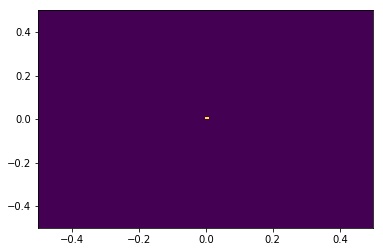

In [8]:
plt.hist2d(source_pos.T[0], source_pos.T[1], 100, [[-1.2*r_source, 1.2*r_source], [-1.2*r_source, 1.2*r_source]]);

In [15]:
source_intersection = []

dist_source = 4.3
areaPoint  = np.array([0, 0, dist_source])
areaNormal = np.array([0, 0, 1])
areaRadius = 5

for n in range(n_events):
    if source_dir[n,2]>0:
        intersection = LineCircleCollision(areaRadius, areaNormal, areaPoint, source_dir[n], source_pos[n])
        source_intersection += [intersection] if intersection is not None else []
source_intersection = np.array(source_intersection)
        
print(f'Estimation from simulation =  {100*len(source_intersection)/(n_events):.3f}%') 
print(f'Analytic value = {100*0.5*(1-dist_source/np.sqrt(dist_source**2 + areaRadius**2)):.3f}%')

Estimation from simulation =  17.190%
Analytic value = 17.398%


In [25]:
def generateSource(sourceOrigin=[0,0,0], sourceRadius=5, n_events=10e4):
    source_pos = list(pol2cart(np.sqrt(np.random.rand(n_events))*sourceRadius , 2*np.pi*np.random.rand(n_events)) + np.array([sourceOrigin[0], sourceOrigin[1]]).reshape(2,1))
    source_pos.append(np.array(n_events*[sourceOrigin[2]]))
    source_pos = np.array(source_pos).T

    source_dir = np.array(sphe2cart([1]*n_events, 
                          2*np.pi*np.random.rand(n_events), 
                          np.arccos(2*np.random.rand(n_events)-1))).T
    return source_pos, source_dir

In [27]:
def interactionPoints(source_pos, source_dir, cylinderRadius=5, cylinderHeight=10, dist=5):
    for n, position in enumerate(source_pos):
        if source_dir[n,2]>0:
            intersection = LineCylinderCollision(areaRadius, cylinder_centers, source_dir[n], position)
            source_intersection += [intersection] if intersection is not None else []
    return np.array(source_intersection)

In [388]:
source_intersection = []
dist_source = 4.3
cylinder_centers = np.array([[0, 0, dist_source], [0, 0, dist_source+10]])

for n in range(n_events):
    if source_dir[n,2]>0:
        intersection = LineCylinderCollision(areaRadius, cylinder_centers, source_dir[n], source_pos[n])
        source_intersection += [intersection] if intersection is not None else []
source_intersection = np.array(source_intersection)
        
print(f'Estimation from simulation =  {100*len(source_intersection)/(n_events):.3f}%') 
print(f'Analytic value = {100*0.5*(1-dist_source/np.sqrt(dist_source**2 + areaRadius**2)):.3f}%')

Estimation from simulation =  17.430%
Analytic value = 17.398%


In [493]:
source_intersection = []
dist_source = 4.3
cylinder_centers = np.array([[0, 0, dist_source], [0, 0, dist_source+10]])

for n in range(n_events):
    if source_dir[n,2]>0:
        intersection = LineCylinderCollision(areaRadius, cylinder_centers, source_dir[n], np.array([0,0,0]))
        source_intersection += [intersection] if intersection is not None else []
source_intersection = np.array(source_intersection)
        
print(f'Estimation from simulation =  {100*len(source_intersection)/(n_events):.3f}%') 
print(f'Analytic value = {100*0.5*(1-dist_source/np.sqrt(dist_source**2 + areaRadius**2)):.3f}%')

Estimation from simulation =  17.430%
Analytic value = 17.398%


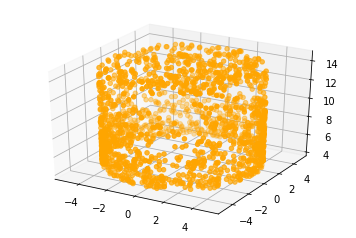

In [531]:
plt3d = plt.figure().gca(projection='3d')
sel = [True] * source_intersection.shape[0]*source_intersection.shape[1] 
sel = np.abs(source_intersection[:,:,2].flatten())!=dist_source
new_source = source_intersection.reshape(source_intersection.shape[0]*source_intersection.shape[1],3)[sel]

plt3d.scatter(new_source[:,0], 
              new_source[:,1],
              new_source[:,2],
              c='orange', marker='o', size='5')
plt.show()

In [505]:
source_intersection[1]

array([[  1.78823412,  -0.43876367,   4.3       ],
       [  4.85596612,  -1.19146675,  11.67668935]])

In [503]:
source_intersection[:,0,:]

array([[-1.9563665 ,  4.2292792 ,  4.3       ],
       [ 1.78823412, -0.43876367,  4.3       ],
       [ 2.32247361,  2.8921585 ,  4.3       ],
       ..., 
       [-0.977936  , -1.27875806,  4.3       ],
       [-2.19240085, -1.81133725,  4.3       ],
       [ 2.80502161, -1.43552993,  4.3       ]])

In [519]:
dx = np.linalg.norm(source_intersection[:,0,:] - source_intersection[:,1,:], axis=1)

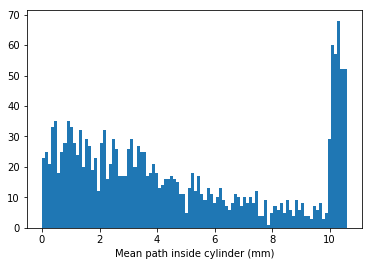

In [524]:
plt.hist(dx,100);
plt.xlabel("Mean path inside cylinder (mm)")

## Inner can circular surface

In [137]:
n_events    = 100000
R_inner_can = 0. 

inner_can_pos = list(pol2cart(np.sqrt(np.random.rand(n_events))*R_inner_can, 0.*2*3.14*np.random.rand(n_events)))
inner_can_pos.append(np.array(n_events*[165.]))
inner_can_pos = np.array(inner_can_pos).T

inner_can_dir = (np.random.rand(n_events,3)-0.5)*2

In [138]:
inner_can_intersection = []

for n in range(n_events):
    inner_can_intersection.append(LinePlaneCollision(planeNormal, planePoint, inner_can_dir[n], inner_can_pos[n]))
inner_can_intersection = np.array(inner_can_intersection)

counts = 0
for intersection in inner_can_intersection:
    x, y = intersection[0], intersection[1]
    if np.sqrt(x*x + y*y) < 40.:
        counts +=1
        
print(100*counts/n_events)

1.479


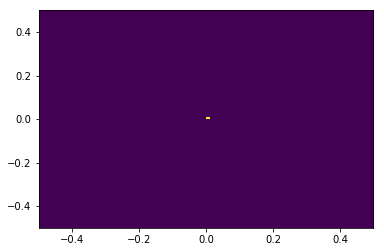

In [139]:
_ = plt.hist2d(inner_can_pos.T[0],inner_can_pos.T[1], [100,100])

## Inner can circular surface

In [106]:
n_events    = 100000
R_inner_can = 38. 

inner_can_pos = list(pol2cart(np.sqrt(np.random.rand(n_events))*R_inner_can, 2*3.14*np.random.rand(n_events)))
inner_can_pos.append(np.array(n_events*[165.]))
inner_can_pos = np.array(inner_can_pos).T

inner_can_dir = np.random.rand(n_events,3)

In [107]:
inner_can_intersection = []

for n in range(n_events):
    inner_can_intersection.append(LinePlaneCollision(planeNormal, planePoint, inner_can_dir[n], inner_can_pos[n]))
inner_can_intersection = np.array(inner_can_intersection)

counts = 0
for intersection in inner_can_intersection:
    x, y = intersection[0], intersection[1]
    if np.sqrt(x*x + y*y) < 40.:
        counts +=1
        
print(100*counts/n_events/2)

0.818


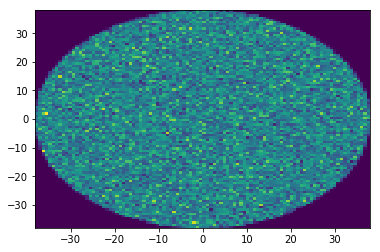

In [108]:
_ = plt.hist2d(inner_can_pos.T[0],inner_can_pos.T[1], [100,100])

## Inner can cylindric surface

In [109]:
n_events    = 100000
R_inner_can = 38. 

inner_cyl_pos = list(pol2cart(n_events*[R_inner_can], 2*3.14*np.random.rand(n_events)))
inner_cyl_pos.append(np.random.rand(n_events)*45. + 120.)
inner_cyl_pos = np.array(inner_cyl_pos).T

inner_cyl_dir = np.random.rand(n_events,3)

In [110]:
inner_cyl_intersection = []

for n in range(n_events):
    inner_cyl_intersection.append(LinePlaneCollision(planeNormal, planePoint, inner_cyl_dir[n], inner_cyl_pos[n]))
inner_cyl_intersection = np.array(inner_cyl_intersection)

counts = 0
for intersection in inner_cyl_intersection:
    x, y = intersection[0], intersection[1]
    if np.sqrt(x*x + y*y) < 40.:
        counts +=1
        
print(100*counts/n_events/2)

1.069


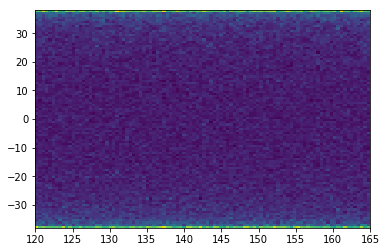

In [104]:
_ = plt.hist2d(inner_cyl_pos.T[2],inner_cyl_pos.T[0], [100,100])

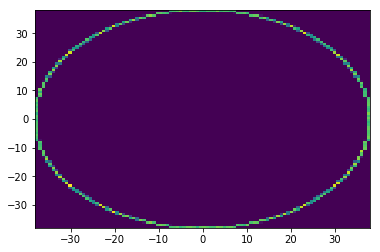

In [102]:
_ = plt.hist2d(inner_cyl_pos.T[0],inner_cyl_pos.T[1], [100,100])

In [113]:
d = 165
r = 40

np.arctan(40/165)*360/np.pi

27.253989719783082

In [118]:
2*np.pi*(1-np.cos(np.arctan(40/165)))*100/(4*np.pi)

1.407494715564761

#### Plane intersection

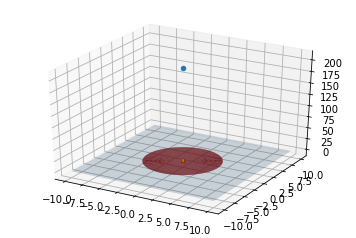

In [282]:
areaPoint  = np.array([0, 0, 0])
areaNormal = np.array([0, 0, 1])
areaRadius = 5
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the areaNormal. Thus, we have to calculate
# d and we're set
d = -areaPoint.dot(areaNormal)

# create x,y
xx, yy = np.meshgrid(np.linspace(-(areaPoint[0]+2*areaRadius), areaPoint[0]+2*areaRadius, 101), 
                     np.linspace(-(areaPoint[1]+2*areaRadius), areaPoint[1]+2*areaRadius, 101))

# calculate corresponding z

z = (-areaNormal[0] * xx - areaNormal[1] * yy - d) * 1. /areaNormal[2]

# plot the surface and its normal
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx, yy, z, alpha=0.2)
plt3d.plot([areaPoint[0], areaPoint[0]+areaNormal[0]], 
           [areaPoint[1], areaPoint[1]+areaNormal[1]], 
           [areaPoint[2], areaPoint[2]+areaNormal[2]], c='orange')
plt3d.scatter(areaPoint[0]+areaNormal[0], areaPoint[1]+areaNormal[1], areaPoint[2]+areaNormal[2], c='orange', marker='^')

#plot the source
plt3d.scatter(0, 0, dist_source)

#plot the region of interest
samples = 100
R = np.linspace(0, areaRadius, samples)
u = np.linspace(0,  2*np.pi, samples)
x = np.outer(R, np.cos(u))
y = np.outer(R, np.sin(u))
plt3d.plot_surface(x,y,0, color='r')

plt.show()